In [1]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import diff_classifier.aws as aws
import pandas as pd
import numpy as np
import mpl_toolkits.mplot3d.axes3d as p3

In [2]:
rfol = '01_18_Experiment/P3'
counter = 0
to_merge = []

for i in range(0, 15):
    n = '{}'.format(i)
    n = n.zfill(4)

    features = 'features_P3_S1_R_{}'.format(n)
    rfile = '{}/{}.csv'.format(rfol, features)
    lfile = '{}.csv'.format(features)

    aws.download_s3(rfile, lfile, bucket_name='ccurtis.data')
    to_merge.append(pd.read_csv(lfile, sep=",", index_col='Unnamed: 0'))

features = pd.concat(to_merge)
features = features.reset_index()
features = features.drop(columns=['index'])

In [8]:
f2 = features[['AR', 'D_fit', 'MSD_ratio', 'alpha', 'asymmetry1']].replace([np.inf, -np.inf], np.nan).dropna(axis=0)

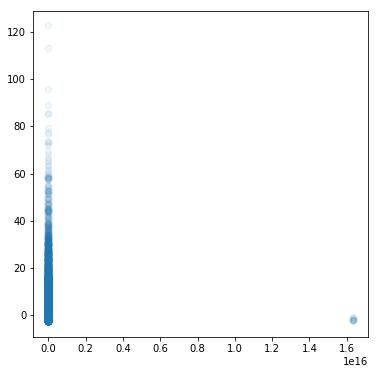

In [9]:
pca = PCA(n_components=2)
f2_r = pca.fit(f1).transform(f2)
lw = 2

plt.figure(figsize=(6, 6))
plt.scatter(f2_r[:, 0], f2_r[:, 1], alpha=0.05, lw=lw)
#plt.xlim([-3.5751*10**12, -3.5750*10**12])
#plt.ylim([-5, 120])
plt.show()

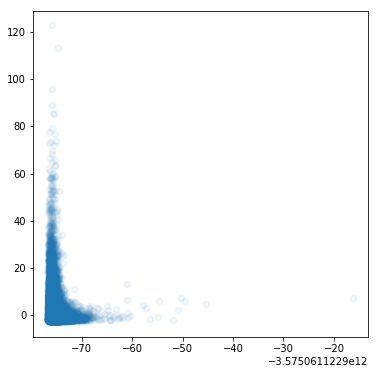

In [10]:
pca = PCA(n_components=2)
f2_r = pca.fit(f2).transform(f2)
test = f2_r[f2_r[:, 0].argsort()][:-12]

lw = 2
f2_r
plt.figure(figsize=(6, 6))
plt.scatter(test[:, 0], test[:, 1], alpha=0.05, lw=lw)
#plt.xlim([-3.5751*10**12, -3.5750*10**12])
#plt.ylim([-5, 120])
plt.show()

In [11]:
from sklearn import cluster, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

0.4198446273803711 seconds
0.6827044486999512 seconds
1.2325236797332764 seconds
1.6843762397766113 seconds
2.152003765106201 seconds
2.2005176544189453 seconds


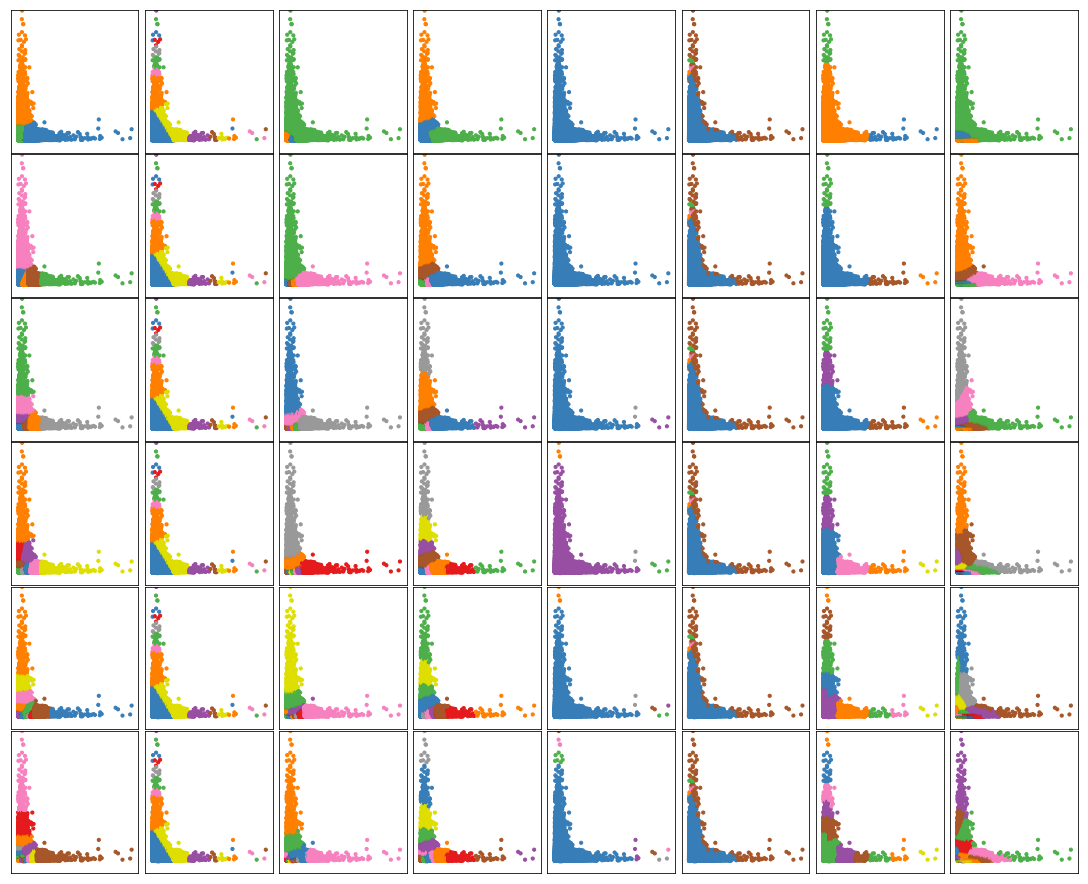

In [31]:
import time
import warnings

plt.figure(figsize=(8*2+3, 12.5))
plt.subplots_adjust(left=0.2, right=0.98, bottom=0.001, top=.96, wspace=0.05, hspace=0.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

test = StandardScaler().fit_transform(test)

plot_num = 1
for num in [3, 5, 7, 9, 12, 15]:
    t0 = time.time()
    bandwidth= cluster.estimate_bandwidth(test, quantile=default_base['quantile'])
    connectivity= kneighbors_graph(test, n_neighbors=default_base['n_neighbors'], include_self=False)
    connectivity = 0.5 * (connectivity + connectivity.T)

    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=num)
    ward = cluster.AgglomerativeClustering(n_clusters=num, linkage='ward', connectivity=connectivity)
    spectral = cluster.SpectralClustering(n_clusters=num, eigen_solver='arpack', affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=default_base['eps'])
    affinity_propagation = cluster.AffinityPropagation(damping=default_base['damping'], preference=default_base['preference'])
    average_linkage = cluster.AgglomerativeClustering(linkage='average', affinity='cityblock',
                                                      n_clusters=num, connectivity=connectivity)
    birch = cluster.Birch(n_clusters=num)
    gmm = mixture.GaussianMixture(n_components=num, covariance_type='full')

    clustering_algorithms = (('MiniBatchKMeans', two_means), ('MeanShift', ms), ('SpectralClustering', spectral), ('Ward', ward), ('AgglomerativeClustering', average_linkage), ('DBScan', dbscan), ('Birch', birch), ('GaussianMixture', gmm))

    for name, algorithm in clustering_algorithms:
        

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="the number of connected components of the", category=UserWarning)
            warnings.filterwarnings("ignore", message="Graph is not fully connected spectral embedding", category=UserWarning)
            algorithm.fit(test)

        
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(test)

        plt.subplot(6, len(clustering_algorithms), plot_num)
        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(test[:, 0], test[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 20)
        plt.ylim(-2.5, 20)
        plt.xticks(())
        plt.yticks(())
        plot_num += 1
    t1 = time.time()   
    print("{} seconds".format(t1-t0))

plt.show()

In [ ]:
import time
import warnings

plt.figure(figsize=(8*2+3, 12.5))

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

test = StandardScaler().fit_transform(test)

num = 12
t0 = time.time()

birch = cluster.Birch(n_clusters=num)
name = "Birch"
algorithm = birch

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="the number of connected components of the", category=UserWarning)
    warnings.filterwarnings("ignore", message="Graph is not fully connected spectral embedding", category=UserWarning)
    algorithm.fit(test)


if hasattr(algorithm, 'labels_'):
    y_pred = algorithm.labels_.astype(np.int)
else:
    y_pred = algorithm.predict(test)

262.8886263370514 seconds


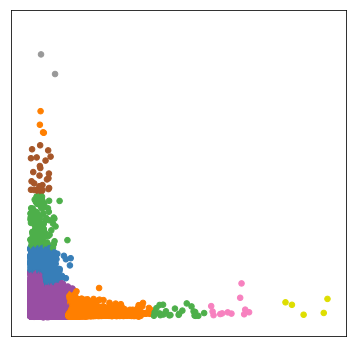

In [35]:
plt.figure(figsize=(6, 6))
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                     '#f781bf', '#a65628', '#984ea3',
                                     '#999999', '#e41a1c', '#dede00']),
                              int(max(y_pred) + 1))))
plt.scatter(test[:, 0], test[:, 1], s=30, color=colors[y_pred])

plt.xlim(-2.5, 20)
plt.ylim(-2.5, 30)
plt.xticks(())
plt.yticks(())
plot_num += 1
t1 = time.time()   
print("{} seconds".format(t1-t0))

plt.show()